In [1]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
full_name = 'Dmitry Polovnikov'
random_state = sum(map(ord,full_name))

In [39]:
MLDATA_PATH = 'moex_top.csv'
mldata = pd.read_csv(MLDATA_PATH,index_col=0)
mldata = mldata.ffill()
mldata = mldata.pct_change().shift(-1)
mldata = mldata.dropna()
mldata.index = pd.to_datetime(mldata.index)

In [10]:
DEVICE = 'cpu'

In [11]:
universe_size = mldata.shape[1]
m_tensor = torch.tensor(mldata.values,dtype=torch.float32).to(DEVICE)
m_tensor.shape

torch.Size([2519, 78])

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self,
                 n_features, 
                 hidden_sizes, 
                 activation_func):
        """
            hidden_sizes = [...]
        """
        super().__init__()
        
        encoder_layers = [
            nn.Linear(n_features,hidden_sizes[0]),
            activation_func()
        ]
        
        for i in range(1,len(hidden_sizes)):
            encoder_layers += [
                nn.Linear(hidden_sizes[i-1],hidden_sizes[i]), activation_func()
            ]
            
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        for i in range(len(hidden_sizes)-1,0,-1):
            decoder_layers += [
                nn.Linear(hidden_sizes[i], hidden_sizes[i-1]), activation_func()
            ]
            
        decoder_layers += [nn.Linear(hidden_sizes[0],n_features),activation_func()]
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self,x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        
        return x_decoded

In [13]:
model = AutoEncoder(universe_size, [32,8], nn.Tanh).to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
losses = []

In [15]:
def fit_nn(N_epochs, m_tensor):
    for _ in range(N_epochs):
        predicted = model(m_tensor)
        loss = loss_func(predicted, m_tensor)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#### online fit and predict and PnL

In [24]:
%%time
window = 40

model = AutoEncoder(universe_size, [32,8], nn.Tanh).to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
pnl=np.zeros(mldata.shape[0]-window)

for report_day in range(window, mldata.shape[0]-3):
    m_tensor = torch.tensor((mldata.iloc[report_day-window:report_day]).values, dtype=torch.float32).to(DEVICE)
    if report_day % 100 == 0:
        print(f'dates : {mldata.index[report_day-window], mldata.index[report_day]}')
    
    fit_nn(10, m_tensor)
    next_day = torch.tensor((mldata.iloc[report_day+1]).values,dtype=torch.float32).to(DEVICE)
    X = model(next_day).detach().numpy()
    
    fair_return = X
    realized_return = np.array(mldata.iloc[report_day+1])
    
    alpha = (fair_return - realized_return) #.shift().fillna(0)
    pnl[report_day-window] = (mldata.iloc[report_day+2] * alpha).sum()

dates : (Timestamp('2012-03-29 00:00:00'), Timestamp('2012-05-24 00:00:00'))
dates : (Timestamp('2012-08-17 00:00:00'), Timestamp('2012-10-12 00:00:00'))
dates : (Timestamp('2013-01-15 00:00:00'), Timestamp('2013-03-13 00:00:00'))
dates : (Timestamp('2013-06-07 00:00:00'), Timestamp('2013-08-05 00:00:00'))
dates : (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-12-24 00:00:00'))
dates : (Timestamp('2014-03-26 00:00:00'), Timestamp('2014-05-23 00:00:00'))
dates : (Timestamp('2014-08-19 00:00:00'), Timestamp('2014-10-14 00:00:00'))
dates : (Timestamp('2015-01-13 00:00:00'), Timestamp('2015-03-12 00:00:00'))
dates : (Timestamp('2015-06-09 00:00:00'), Timestamp('2015-08-05 00:00:00'))
dates : (Timestamp('2015-10-28 00:00:00'), Timestamp('2015-12-24 00:00:00'))
dates : (Timestamp('2016-03-24 00:00:00'), Timestamp('2016-05-24 00:00:00'))
dates : (Timestamp('2016-08-17 00:00:00'), Timestamp('2016-10-12 00:00:00'))
dates : (Timestamp('2017-01-06 00:00:00'), Timestamp('2017-03-06 00:00:00'))

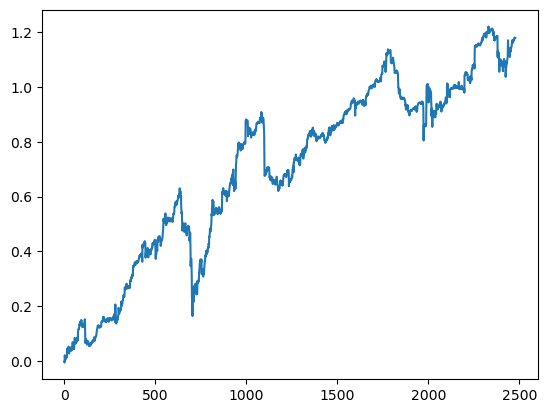

In [25]:
a = np.where(abs(pnl)>0.1, 0, pnl)
plt.plot(a.cumsum())

#### JAX REALIZATION (in progress - it still doesn't work)

In [16]:
# %env CUDA_VISIBLE_DEVICES=-1
# if torch.cuda.is_available():
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
from jax import random
random_state_key = random.PRNGKey(random_state)

# flax = NN in JAX
import flax
from flax import linen as fnn
from flax.training import train_state, checkpoints

# optax is JAX optimizer
import optax

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

I0000 00:00:1696073095.907221 1060831 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-09-30 11:24:56.049794: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 34089926656
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-09-30 11:24:56.734134: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 11:24:57.294352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-30 11:24:57.294413: W tensorflow/stream_executor/platform/default/dso_l

In [17]:
class jAutoEncoder(fnn.Module):
    n_features : int
    hidden_sizes : int
    
    def setup(self):
        """
            hidden_sizes = [...]
        """
        super().__init__()
        
        encoder_layers = [
            fnn.Dense(features=self.hidden_sizes[0])
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            encoder_layers += [
                fnn.Dense(features=self.hidden_sizes[i])
            ]
            
        self.encoder = fnn.Sequential(encoder_layers)
        
        decoder_layers = []
        for i in range(len(self.hidden_sizes)-1,0,-1):
            decoder_layers += [
                fnn.Dense(features=self.hidden_sizes[i])
            ]
            
        decoder_layers += [fnn.Dense(features=self.n_features)]
        self.decoder = fnn.Sequential(decoder_layers)
        
    def __call__(self,x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        
        return x_decoded

In [18]:
# Same as JAX version but using model.apply().
@jax.jit
def mse(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = jmodel.apply(params, x)
    return jnp.inner(y_batched-pred, y_batched-pred) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
    #print('here')
    return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)

In [19]:
# Same as JAX version but using model.apply().
@jax.jit
def mse(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
        return jnp.inner(x-y, x-y) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)

In [20]:
loss_grad_fn = jax.value_and_grad(mse)

@jax.jit
def update_params(params, learning_rate, grads):
    params = jax.tree_util.tree_map(
    lambda p, g: p - learning_rate * g, params, grads)
    return params

In [21]:
universe_size = R1M.shape[1]
R1M_t = jnp.array(R1M.values)
R1M_t.shape

(124, 1134)

In [22]:
jmodel = jAutoEncoder(universe_size, [32,8])
params = jmodel.init(random_state_key, R1M_t)
y = jmodel.apply(params, R1M_t)

In [23]:
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)
loss_grad_fn = jax.value_and_grad(mse)

In [24]:
def fit_nn():
    global params, opt_state
    for _ in tqdm(range(10000)):
        predicted = jmodel.apply(params, R1M_t)
        loss_val, grads = loss_grad_fn(params, predicted, R1M_t)
        losses.append(loss_val)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        # if i % 10 == 0:
        #     print('Loss step {}: '.format(i), loss_val)

In [25]:
predicted = jmodel.apply(params, R1M_t)

loss_val, grads = loss_grad_fn(params, predicted, R1M_t)
losses.append(loss_val)
updates, opt_state = optimizer.update(grads, opt_state)
params = optax.apply_updates(params, updates)

In [26]:
%%time
fit_nn()
plt.plot(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 